In [1]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import fnmatch
import os

df = pd.read_csv("data//data_streets.csv")

In [3]:
df

,Crime ID,Month,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
0,2163e1bf85d197a93f9c1c6daeb113ad0e0fbd3a8b603f...,2016-01,Avon and Somerset Constabulary,-2.513308,51.409456,On or near Charlton Road,E01014399,Bath and North East Somerset 001A,Burglary,Under investigation
1,74f4fc07b60510a8862f77180de1c8bf1a0755105ec494...,2016-01,Avon and Somerset Constabulary,-2.511761,51.409966,On or near Caernarvon Close,E01014399,Bath and North East Somerset 001A,Burglary,Under investigation
2,6c3dbed2ea67ad837bee1229ccf3951bd48f42e22421fe...,2016-01,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Other theft,Under investigation
3,c12d9c76797195b306f037573eb0f8dde88e21c930d1a1...,2016-01,Avon and Somerset Constabulary,-2.509126,51.416137,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Other theft,Under investigation
4,50a8068b725028cd5565dd9eebccf28810481dd36995a1...,2016-01,Avon and Somerset Constabulary,-2.509126,51.416137,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Other theft,Under investigation
...,...,...,...,...,...,...,...,...,...,...
26277302,49092dec9f064d1f55e4c1274f8cdc1d6050766a0e95a4...,2021-10,Wiltshire Police,-1.758262,50.993385,On or near Salisbury Road,E01031995,Wiltshire 062E,Criminal damage and arson,Under investigation
26277303,baef9c23158d3a83a8c34fb25d27cfb78df23ab526c474...,2021-10,Wiltshire Police,-1.761165,50.991215,On or near Joanna Close,E01031995,Wiltshire 062E,Public order,Under investigation
26277304,735b07a0bb5229f360aa31bb0e6ce458635bc550c3b1e5...,2021-10,Wiltshire Police,-1.737950,50.999681,On or near Barford Lane,E01031995,Wiltshire 062E,Vehicle crime,Under investigation
26277305,368a849dc629c19ba90a46068503a6e4a922ae1e8bfc16...,2021-10,Wiltshire Police,-1.757983,50.992242,On or near The Headlands,E01031995,Wiltshire 062E,Violence and sexual offences,Under investigation


In [22]:
df_coordinates = df[["Longitude", "Latitude"]]
df_coordinates

,Longitude,Latitude
0,-2.513308,51.409456
1,-2.511761,51.409966
2,-2.511927,51.409435
3,-2.509126,51.416137
4,-2.509126,51.416137
...,...,...
26277302,-1.758262,50.993385
26277303,-1.761165,50.991215
26277304,-1.737950,50.999681
26277305,-1.757983,50.992242


In [23]:
df_place = df[["LSOA code", "LSOA name"]]
df_place = pd.DataFrame(df_place["LSOA name"].unique())
df_place

,0
0,Bath and North East Somerset 001A
1,Bath and North East Somerset 001B
2,Bath and North East Somerset 001C
3,Bath and North East Somerset 002A
4,Bath and North East Somerset 002B
...,...
34744,West Devon 005E
34745,Carmarthenshire 019E
34746,Harrogate 008A
34747,Ceredigion 005E


In [24]:
kmeans_kwargs = {"init": "random", 
                 "n_init": 10, 
                 "max_iter": 300, 
                 "random_state": 42
}


features = np.array(df_coordinates)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# A list holds the SSE values for each k
sse = []
for k in tq.tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

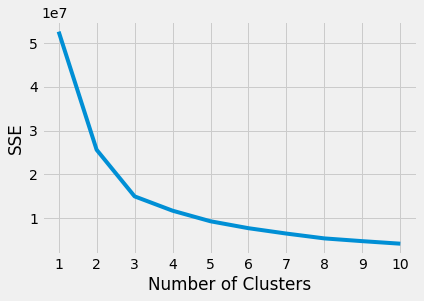

In [30]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [56]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42))
    
    ]
)
clusterer = Pipeline(
    [
        ("kmeans",
         KMeans(
             n_clusters=10,
             init="k-means++",
             n_init=50,
             max_iter=500,
             random_state=42,
             ),
        ),
    ]
)
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)
pipe.fit(df_coordinates.head(1000))

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=10, n_init=50,
                                         random_state=42))]))])

In [65]:
preprocessed_data = pipe["preprocessor"].transform(df_coordinates.head(1000))

predicted_labels= pipe["clusterer"]["kmeans"].labels_

C:\Users\20202016\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


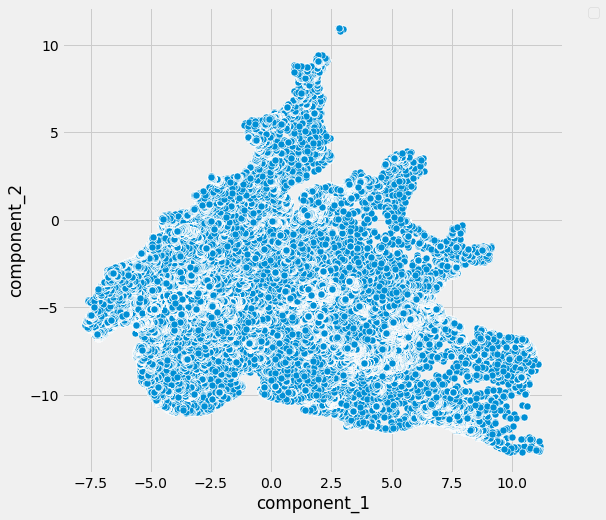

In [70]:
pcadf = pd.DataFrame(
                    pipe["preprocessor"].transform(df_coordinates.head(1000000)),
                    columns=["component_1", "component_2"],
                )

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
        "component_1",
        "component_2",
        s=50,
        data=pcadf,
        palette="Set2",
        )

scat.set_title(
    ""
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
        
plt.show()